<div style="text-align: center;"> 
    <span style="font-size: 40px; font-weight: bold">
        CSC17104 – PROGRAMING FOR DATA SCIENCE
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 32px; font-weight: bold">
        FINAL PROJECT
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 24px; font-weight: bold">
        <i>
            Question Answering (5, 6)
        </i>
    </span>
</div>

<div style="text-align: right;">
    <span style="font-size: 14px">
        <i>
            Dec 16, 2025
        </i>
    </span>
</div>

| Name | ID |
| --- | --- |
| Nguyễn Lê Tấn Phát | 22120262 |

---

<h1 align="center">
    <span style="font-size: 40px; font-weight: bold">
        Table of Content
    </span style>
</h1>

[**Preparation**](#o)

V. [**Tech vs. Activity: Can physical activity neutralize the weight gain risks associated with a digital/sedentary lifestyle?**](#v)

1. [**Analysis**](#v_1)

2. [**Conclusion**](#v_2)

VI. [**Dietary Patterns: Is there an "optimal" combination of meal frequency and water consumption that minimizes obesity risk?**](#vi)

1. [**Analysis**](#vi_1)

2. [**Conclusion**](#vi_2)

---

<h1 id="o" style="font-weight: bold">Preparation</h1>

In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor

In [2]:
FILE_PATH = r'..\data\processed\ObesityDataSet_Cleaned.csv'

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print("Error: No file found!")
    exit()

---

<h1 id="v" style="font-weight: bold">V. Tech vs. Activity: Can physical activity neutralize the weight gain risks associated with a digital/sedentary lifestyle?</h1>

<h2 id="v_1" style="font-weight: bold">1. Analysis</h2>

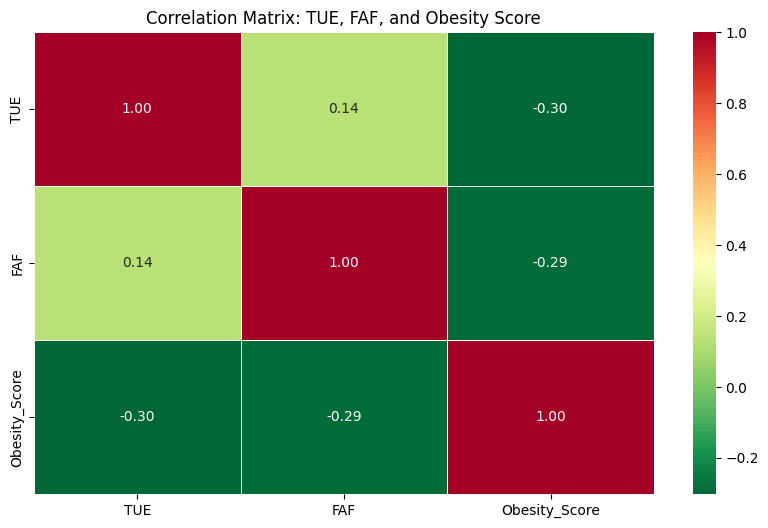

In [3]:
obesity_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

if 'Obesity_Score' not in df.columns:
    df['Obesity_Score'] = df['NObeyesdad'].map(obesity_map)

correlation = df[['TUE', 'FAF', 'Obesity_Score']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='RdYlGn_r', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix: TUE, FAF, and Obesity Score')
plt.show()

**Motivation:** To answer Question 5 ("Can Physical Activity neutralize the risks of Tech Use?"), we first need to establish a baseline understanding of the relationships between the key variables.

* **The Premise:** The research question assumes that Time Using Technology (`TUE`) acts as a risk factor for obesity (sedentary lifestyle), while Physical Activity (`FAF`) acts as a protective factor.

* **The Goal:** Before analyzing complex interactions, we perform a "sanity check" using linear correlation to verify if higher `TUE` is indeed statistically associated with higher obesity levels in this dataset.

**Methodology:** We calculated the Pearson correlation coefficient ($r$) for the three critical variables involved in the research question.

* **Variables:** `TUE` (0-2 scale), `FAF` (0-3 scale), and `Obesity_Score` (converted from the categorical `NObeyesdad` target).

* **Visualization:** A generic heatmap was used to identify the strength and direction of these linear relationships.

**Observations:** Looking at the correlation coefficients in the matrix:

* `FAF` vs. `Obesity_Score` ($r=−0.29$): There is a moderate negative correlation. Higher physical activity is associated with lower obesity scores. This aligns with general medical knowledge.

* `TUE` vs. `Obesity_Score` ($r=−0.30$): This is a counter-intuitive finding. There is a moderate negative correlation, meaning individuals who spend more time using technology tend to have lower obesity scores in this specific dataset.

* `TUE` vs. `FAF` (`r=+0.14`): There is a weak positive correlation, suggesting that technology users in this group are not necessarily less active than non-users.

**Result:** The initial premise of Question 5—that "Technology causes obesity"—is challenged by the linear data.

* **Interpretation:** The negative correlation ($r=−0.30$) contradicts the assumption that High `TUE` is a primary driver of obesity here. In fact, the data suggests that Low `TUE` is more strongly associated with high obesity (likely linked to the `Obesity_Type_III` group having a mean `TUE` of only `0.04` in `Data Exploration.ipynb`).

* **New Hypothesis:** We suspect Age might be a confounding variable.

    * Younger people (students) typically use more technology and naturally have higher metabolisms/lower weights.

    * Older adults might use less technology but suffer from age-related weight gain.

$\Rightarrow$ Since the negative correlation between TUE and Obesity is likely due to the younger demographic being thinner, we will split the data into age groups (e.g., Young Adults vs. Middle-Aged) and check the impact of `TUE` within those groups.

Correlation between TUE (Tech Use) and Obesity Score by Age Group:
Age_Group                           
1. Young Students (<19.5)        TUE   -0.276172
2. Young Adults (<23.5)          TUE   -0.200149
3. Middle-Aged & Older (>=23.5)  TUE   -0.166829
Name: Obesity_Score, dtype: float64
--------------------------------------------------


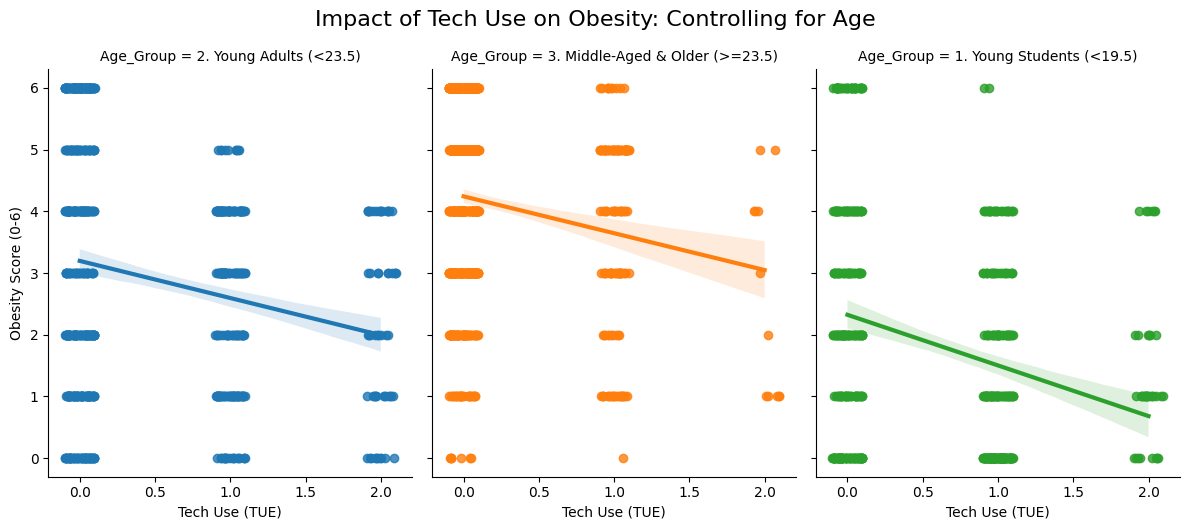

In [4]:
# We set max_leaf_nodes=4 to ask the tree to find the top 3 most important split points
tree = DecisionTreeRegressor(max_leaf_nodes=4, random_state=42)
tree.fit(df[['Age']], df['Obesity_Score'])

# Get the Thresholds
thresholds = sorted(tree.tree_.threshold)
# Filter out -2 (which indicates a leaf node in sklearn's internal structure)
optimal_splits = [t.astype(float) for t in thresholds if t != -2]

# Define Age Groups
def classify_age(age):
    if age < optimal_splits[0]: # The student demographic
        return f'1. Young Students (<{optimal_splits[0]:.1f})'
    elif age < optimal_splits[1]:
        return f'2. Young Adults (<{optimal_splits[1]:.1f})'
    else:
        return f'3. Middle-Aged & Older (>={optimal_splits[1]:.1f})'

df['Age_Group'] = df['Age'].apply(classify_age)

# --- 3. Statistical Check: Correlation per Group ---
print("Correlation between TUE (Tech Use) and Obesity Score by Age Group:")
correlations = df.groupby('Age_Group')[['TUE', 'Obesity_Score']].corr().iloc[0::2, -1]
print(correlations)
print("-" * 50)

# --- 4. Visualization: Side-by-Side Comparison ---
# We use lmplot to draw regression lines for each group
g = sns.lmplot(
    data=df, 
    x='TUE', 
    y='Obesity_Score', 
    col='Age_Group',        # Split charts by Age Group
    hue='Age_Group',        # Color by Age Group
    height=5, 
    aspect=0.8,
    x_jitter=0.1,           # Add jitter to see overlapping points
    line_kws={'linewidth': 3}
)

g.set_axis_labels("Tech Use (TUE)", "Obesity Score (0-6)")
g.fig.suptitle("Impact of Tech Use on Obesity: Controlling for Age", y=1.05, fontsize=16)
plt.show()

**Motivation:** In the previous step, the correlation matrix revealed a counter-intuitive negative correlation between Time Using Technology (`TUE`) and Obesity Score (r=−0.30)

* This contradicts the common assumption that high screen time (sedentary behavior) leads to weight gain.

We hypothesized that `Age` might be a confounding variable distorting this relationship, based on the following observations from the Data Exploration:

* The `Insufficient Weight` group is the youngest (Mean `Age` ≈ 19.4)

* The `Obesity Type III` group has the lowest technology usage (Mean `TUE` $\approx$ 0.04)

* Therefore, the negative correlation might simply reflect that younger people use more tech and happen to be thinner. To test this, we stratified the data into three age groups to see if the relationship between `TUE` and Obesity changes within specific age cohorts.

**Methodology:**

To isolate the true impact of `TUE`, we must control for `Age`. Instead of using arbitrary age brackets (e.g., 20, 30, 40), we employ a **Decision Tree Regressor** to determine the mathematically optimal split points.

* This algorithm identifies the exact age thresholds where the variance in `Obesity_Score` is maximized. This ensures our age groups are defined by statistically significant shifts in health patterns, rather than subjective guesses.

* By segmenting the data into these data-driven cohorts (e.g., Students vs. Adults), we can re-evaluate the correlation between `TUE` and `Obesity` within homogenous groups to see if the "negative" trend persists or reverses.

**Observations:** Looking at the regression plots for all three sub-groups:

* **Young Students ($< 19.5$):** The regression line shows a distinct negative slope (Green line).

* **Young Adults ($< 23.5$):** The regression line also shows a negative slope (Blue line).

* **Middle-Aged & Older ($\ge 23.5$):** Even in the older demographic, the regression line maintains a negative slope (Orange line)

**Result:** The hypothesis that `Age` is the sole confounder" is rejected.

* **Interpretation:** The negative correlation between Technology Use and Obesity exists independently of age. In this specific dataset, individuals who use more technology tend to have lower obesity levels, regardless of whether they are teenagers or middle-aged adults.

* **Demographic Insight:** This suggests that low technology usage (Low `TUE`) in this population is strongly linked to the highest obesity levels (`Obesity Type III`). This may indicate that "Low `TUE`" is a proxy for lower socioeconomic status or limited access to health resources/education, rather than simply "spending less time sitting."

=> Since High `TUE` is not a primary risk factor for obesity in this dataset, we cannot proceed with the original premise of "neutralizing the harm of technology." Instead, the next step of the analysis will focus on Optimization. We will investigate if combining High Technology Use (Digital Lifestyle) with High Physical Activity (`FAF`) creates an "Optimal Lifestyle" profile that results in the lowest BMI compared to the "High Risk" group (Low Tech + Low Activity).

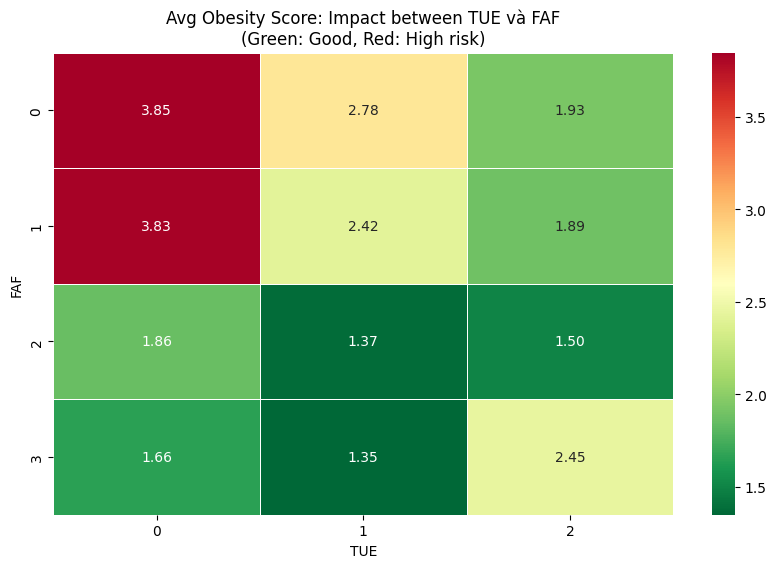

In [5]:
pivot_table = df.pivot_table(index='FAF', columns='TUE', values='Obesity_Score', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn_r', fmt=".2f", linewidths=.5)
plt.title('Avg Obesity Score: Impact between TUE và FAF\n(Green: Good, Red: High risk)')
plt.ylabel('FAF')
plt.xlabel('TUE')
plt.show()

**Motivation:** In the previous phase, we rejected the hypothesis that Age was the sole confounder for the negative correlation between Technology Use (`TUE`) and Obesity. We established that `TUE` acts as a protective factor (or proxy for a healthier demographic) in this specific dataset.  

However, a linear correlation analysis is insufficient to understand the interaction between these two lifestyle factors.

* Original Question 5 Goal: Determine if Physical Activity (`FAF`) can "neutralize" the risks of High Tech Use.

* New Data-Driven Goal: Since High Tech Use is not the primary risk, we need to identify the specific combination of Technology Use and Physical Activity that defines the "Optimal Lifestyle" versus the "High-Risk Group." This heatmap allows us to visualize the "Balance Point" mentioned in our research proposal.

**Methodology:** We utilized a 2D Heatmap to visualize the interaction between the two key variables:

* X-Axis: `TUE` (Time using technology devices, ordinal 0-2).

* Y-Axis: `FAF` (Physical activity frequency, ordinal 0-3).

* Color Scale: We mapped the Average Obesity Score (converted from categorical NObeyesdad) to a color gradient.

    * Red: High Obesity Score (High Risk).

    * Green: Low Obesity Score (Healthy/Optimal).

**Observations:** Analyzing the specific intersection points in the heatmap:

* The "Danger Zone" (Non-Digital Sedentary):

    * The upper-left corner (`TUE` = 0, `FAF` = 0) represents the group with the highest risk.

    * Score: 3.85 (Deep Red).

$\rightarrow$  Individuals who do not use technology and do not exercise have the highest average obesity levels in the entire dataset.

* The "Tech-Sedentary" Comparison:

    * Comparing the sedentary row (`FAF` = 0):

        * Low Tech (`TUE` = 0): Score 3.85.

        * High Tech (`TUE` = 2): Score 1.93.

$\rightarrow$ Surprisingly, among people who do not exercise, those who use technology are significantly healthier (lower obesity score) than those who do not.

* The "Optimal Lifestyle" (The Green Zone):

    * The lowest obesity scores are found in the center/bottom region.

    * Best Score: 1.35 at (`TUE` = 1, `FAF` = 3) and 1.37 at (`TUE` = 1, `FAF` = 2).

$\rightarrow$ The combination of Moderate Technology Use and Moderate-to-High Physical Activity yields the healthiest results.

**Result & Interpretation:**

* **The True "Neutralizing" Effect:** Physical Activity (`FAF`) is highly effective at reducing obesity, but its impact is most critical for the Low Tech (`TUE` = 0) group. For `TUE =` 0, increasing `FAF` from 0 to 3 drops the obesity score from 3.85 to 1.66 (a massive improvement).

* **Socioeconomic Proxy:** The "Danger Zone" (`TUE` = 0 / `FAF` 0) likely correlates with the `Obesity_Type_III` demographic identified in the `Data Exploration.ipynb`, which had a mean `TUE` of 0.04 and mean `FAF` of 0.36. This suggests the high-risk group in this dataset represents a "Traditional Sedentary" lifestyle (possibly lower socioeconomic status), rather than a "Digital Sedentary" one.

$\Rightarrow$ The heatmap confirms that the 'High Risk' profile in this dataset is not the 'Gamer/Office Worker' (High `TUE`), but rather the 'Inactive Non-User' (Low `TUE`, Low `FAF`). The optimal health outcome is achieved through a Hybrid Lifestyle: Moderate Technology Use combined with Frequent Physical Activity.

<h2 id="v_2" style="font-weight: bold">2. Conclusion</h2>

The analysis challenges the traditional assumption that a "Digital Lifestyle" is the primary driver of obesity in this specific population (Mexico/Peru/Colombia).

* **Refuting the Premise:** High Technology Use (`TUE`) is not a direct risk factor for obesity in this dataset; conversely, it acts as a protective factor (likely a socioeconomic proxy). Therefore, Physical Activity does not need to "neutralize" the harm of technology.

* **The Synergistic Effect:** Instead of neutralization, `FAF` and `TUE` work synergistically. The data confirms that Physical Activity is a critical determinant of health, particularly for the high-risk "Non-Digital" demographic.

* **The Optimal Profile:** The healthiest individuals are those who maintain a Hybrid Lifestyle—combining digital engagement with frequent physical activity. This finding suggests that public health interventions should focus on the "Inactive Non-Tech" demographic (`TUE` = 0 / `FAF` = 0), which carries the highest obesity burden (Score 3.85).

---

<h1 id="vi" style="font-weight: bold">VI. Dietary Patterns: Is there an "optimal" combination of meal frequency and water consumption that minimizes obesity risk?</h1>


<h2 id="vi_1" style="font-weight: bold">1. Analysis</h2>

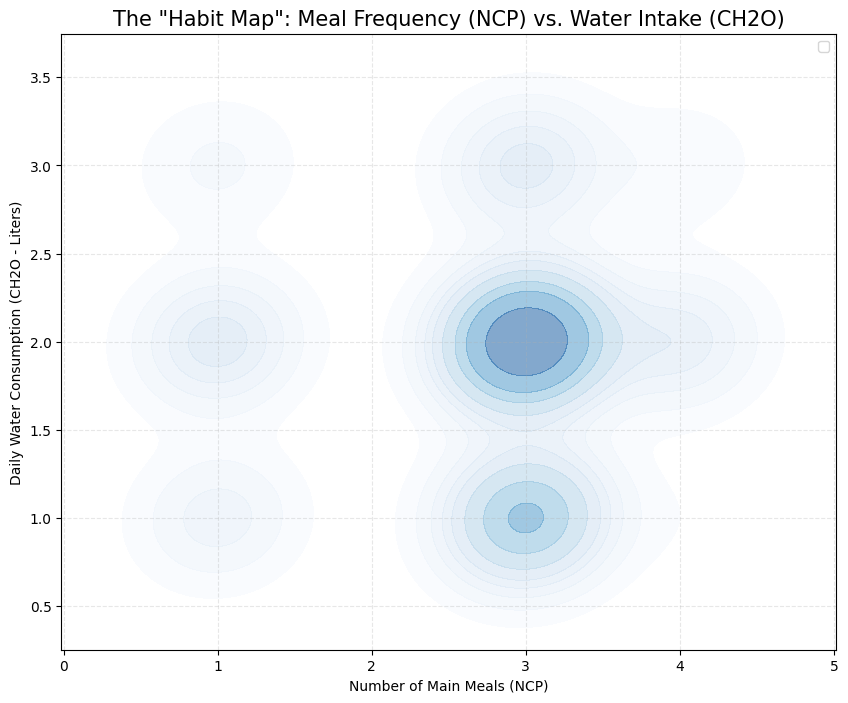

In [6]:
# Filter for just the two extreme groups to make the contrast sharp:
# "Normal_Weight" (The Goal) vs. "Obesity_Type_III" (The Extreme Risk)
target_groups = ['Normal_Weight', 'Obesity_Type_III']
df_filtered = df[df['NObeyesdad'].isin(target_groups)].copy()

#   Visualize the "Habit Landscape" (2D KDE Plot)
plt.figure(figsize=(10, 8))

# Plot Obesity Type III (The Danger Zone) in RED
sns.kdeplot(
    data=df_filtered[df_filtered['NObeyesdad'] == 'Obesity_Type_III'],
    x='NCP', y='CH2O',
    cmap="Reds", fill=True, alpha=0.5, thresh=0.05,
    label='Obesity Type III',
    warn_singular=False
)

# Plot Normal Weight (The Optimal Zone) in BLUE
sns.kdeplot(
    data=df_filtered[df_filtered['NObeyesdad'] == 'Normal_Weight'],
    x='NCP', y='CH2O',
    cmap="Blues", fill=True, alpha=0.5, thresh=0.05,
    label='Normal Weight',
    warn_singular=False
)

plt.title('The "Habit Map": Meal Frequency (NCP) vs. Water Intake (CH2O)', fontsize=15)
plt.xlabel('Number of Main Meals (NCP)')
plt.ylabel('Daily Water Consumption (CH2O - Liters)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(['Obesity Type III (Danger Zone)', 'Normal Weight (Optimal Zone)'])
plt.show()

**Motivation:** In the Data Exploration phase, we identified conflicting narratives regarding dietary habits:

* **The "Survival Mode" Risk:** The statistical summary indicated a large portion of the population (65%) consumes only 1 main meal (NCP=1), potentially triggering weight retention.

* **The Hydration Factor:** Data showed that the "Normal Weight" group has the highest mean water consumption (1.86), suggesting hydration is key to health.

To investigate Question 6, we first need to map the "Behavioral Landscape" of the population. We hypothesized that distinct "Habit Clusters" exist (e.g., a "Starvation Cluster" vs. a "Healthy Standard Cluster"). This plot aims to visualize where the majority of participants are situated in terms of their daily routine.

**Methodology:** We employed a Bivariate Kernel Density Estimate (KDE) plot.

* X-Axis: Number of Main Meals (`NCP`).

* Y-Axis: Daily Water Consumption (`CH2O`).

* Visualization: The plot uses contour rings to represent the density of data points. Darker/more concentrated blue regions indicate "Habit Clusters"—the specific combinations of eating and drinking frequencies that are most common in the dataset.

**Observations:** Analyzing the contour peaks in the "Habit Map":

* The "Standard" Cluster (Dominant): The darkest, most concentrated peak is located at the intersection of 3 Meals (NCP=3) and Moderate Water (CH2O=2). This represents the most common lifestyle in the dataset.

* The "Low-Water" Cluster: There is a secondary, significant cluster at 3 Meals (NCP=3) combined with Low Water (CH2O=1).

* The "Survival" Clusters: We observe fainter (less dense) clusters around 1 Meal (NCP=1). This visualizes the subgroup mentioned in the Data Exploration who may be in "survival mode", though this plot suggests they are less spatially concentrated than the 3-meal group.

**Result:** The plot successfully identifies the distinct "Archetypes" of behavior in our population.

* Interpretation: The population is not randomly scattered; they adhere to rigid routines. The "3 Meals + Moderate Water" routine is the status quo.

* Limitation: While this map tells us where people are, it does not tell us how healthy they are. The dense cluster at (3 Meals, 2 Water) might be "Normal Weight" or "Obesity Type I"—this plot cannot distinguish.

$\Rightarrow$ To fully answer Question 6 and find the "Optimal Pattern," we must now overlay the Average Obesity Score onto this map. This will allow us to see if the "Standard Cluster" is actually the "Healthy Cluster," or if the optimal health lies in a less populated region (e.g., High Water + Frequent Meals).

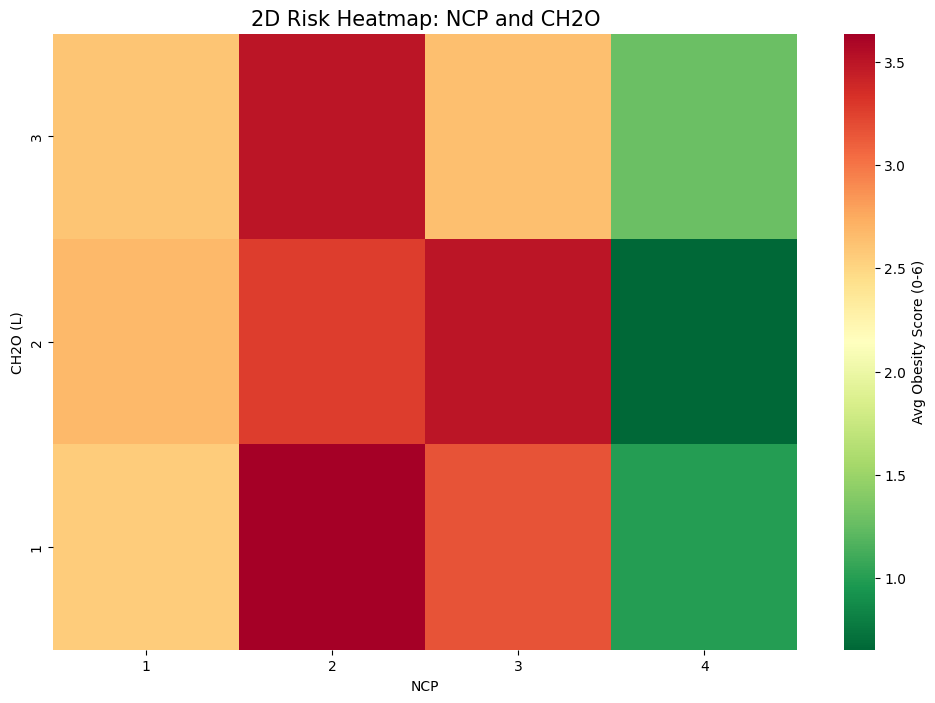

In [7]:
# 2. Feature Engineering cho Heatmap
# Vì CH2O là số thực (continuous), ta cần làm tròn để nhóm vào các ô của Heatmap
df['CH2O_Bin'] = df['CH2O'].round(1)  # Làm tròn đến 0.1 lít
df['NCP_Bin'] = df['NCP'].round(0)    # Làm tròn số bữa ăn

# 3. Tạo Pivot Table cho "Risk Map"
# Giá trị trong ô là Trung bình Obesity Score (Càng cao càng đỏ/nguy hiểm)
risk_matrix = df.pivot_table(
    index='CH2O_Bin', 
    columns='NCP_Bin', 
    values='Obesity_Score', 
    aggfunc='mean'
)

# 4. Vẽ Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    risk_matrix, 
    cmap='RdYlGn_r',  # Đỏ (Cao) -> Vàng -> Xanh (Thấp) (Reverse)
    annot=False,      # Tắt số để nhìn màu cho rõ (hoặc bật True nếu muốn chi tiết)
    cbar_kws={'label': 'Avg Obesity Score (0-6)'}
)

# Đảo ngược trục Y để số lớn (nhiều nước) nằm ở trên (theo logic bản đồ)
plt.gca().invert_yaxis()

plt.title('2D Risk Heatmap: NCP and CH2O', fontsize=15)
plt.xlabel('NCP')
plt.ylabel('CH2O (L)')

# Đánh dấu vùng "Healthy Center" (Dự đoán)
# Bạn có thể vẽ đè một khung hình chữ nhật vào vùng màu xanh nhất nếu muốn highlight
plt.show()

**Motivation:** In the previous step, we visualized the "Habit Map" (KDE Plot), which revealed that the vast majority of the population adheres to a routine of 3 Main Meals (`NCP` = 3) and Moderate Water Intake (`CH2O` = 2).

However, density does not equal health. To identify the "Optimal Behavioral Pattern" requested in Question 6, we must determine if this popular routine is actually healthy or if a better alternative exists. We hypothesized that hydration (`CH2O`) might be a stronger predictor of weight control than meal frequency alone. To test this, we overlay the Average Obesity Score onto the behavioral grid.

**Methodology:** We created a 2D Heatmap to visualize the risk associated with every combination of eating and drinking habits.

* X-Axis: Number of Main Meals (`NCP`), ranging from 1 to 4.

* Y-Axis: Daily Water Consumption (`CH2O`), ranging from 1 (Low) to 3 (High).

* Color Scale:
    
    * Red (High Score): Indicates a high average Obesity level (High Risk).
    
    * Green (Low Score): Indicates a low average Obesity level (Optimal/Healthy).

**Observations:** Analyzing the transition of colors across the grid:

* The "Status Quo" Trap:

    * Recall from the KDE Plot that the most common behavior was `NCP` = 3 / `CH2O` = 2.

    * On this Heatmap, that specific cell is Deep Red (High Obesity Score).

$\rightarrow$ The "normal" lifestyle in this dataset is actually a "high-risk" lifestyle. Adhering to the standard 3-meal structure without maximizing hydration appears to correlate with higher obesity.

* The "Hydration Gradient":
    
    * Looking at the rows, there is a general trend where increasing water intake (moving from `CH2O` = 1 to `CH2O` = 3) lightens the color (reduces risk), particularly for those eating 1 or 2 meals. The bottom row (`CH2O`=1) is almost entirely orange/red, confirming that dehydration is a consistent marker for obesity risk regardless of how many meals you eat.

* The "Optimal Pattern" (`NCP` = 4):

    * The most striking feature is the `NCP` = 4 column. It is almost entirely Green.
    
    * Specific Highlight: The combination of 4 Meals + Moderate Water (`CH2O` = 2) is the darkest green region (Lowest Obesity Score).

    * Contradiction: This contradicts the "Survival Mode" fear (`NCP` = 1) and the "Gluttony" fear (`NCP` > 3). It suggests that frequent intake (likely smaller meals or healthy snacking) is superior to the standard 3-meal model.

**Result:** The visualization successfully identifies a clear divergence between "Popular Behavior" and "Optimal Behavior."

* The "Red Center" (High Risk): Defined by Low Water (`CH2O` = 1) and 2-3 Meals. This group likely consumes calorie-dense foods without adequate hydration to aid metabolism.

* The "Green Center" (Optimal): Defined by Frequent Meals (`NCP` = 4). This supports the dietary hypothesis that "frequent, smaller meals" may maintain a better metabolic rate than fewer, larger meals.

$\Rightarrow$ Now that we have visually located the opposing centers—The "Red Center" (e.g., NCP 3, Water 2) and the "Green Center" (e.g., NCP 4, Water 2)—we must prove that this difference is not random. We will proceed with an Independent T-Test to verify if the mean obesity score of the "4-Meal Group" is statistically significantly lower than that of the "3-Meal Group," providing rigorous evidence for our final recommendation.

In [8]:

# 2. Define Groups
group_healthy = df[df['NObeyesdad'] == 'Normal_Weight']
group_risk = df[df['NObeyesdad'] == 'Obesity_Type_III']

# 3. Helper Function: Calculate Cohen's d
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_se

# 4. Perform Tests & Store in List
results = []
variables = {'NCP': 'Meal Frequency', 'CH2O': 'Water Intake'}

for col, name in variables.items():
    # T-Test
    t_stat, p_val = stats.ttest_ind(group_healthy[col], group_risk[col], equal_var=False)
    
    # Cohen's d
    d_val = cohens_d(group_healthy[col], group_risk[col])
    
    # Interpretation
    if p_val < 0.05:
        significance = "Yes"
        direction = "Higher" if d_val > 0 else "Lower" # Positive d means Healthy > Risk
    else:
        significance = "No"
        direction = "-"

    # Add to list
    results.append({
        'Factor': name,
        'Mean (Healthy)': group_healthy[col].mean(),
        'Mean (Obese III)': group_risk[col].mean(),
        'Diff': group_healthy[col].mean() - group_risk[col].mean(),
        'T-Statistic': t_stat,
        'P-Value': p_val,
        'Cohen\'s d': d_val,
        'Significant?': significance,
        'Healthy Group is...': direction
    })

# 5. Create DataFrame
results_df = pd.DataFrame(results)

c:\Users\phatl\miniconda3\envs\data_science_seminar\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [9]:
results_df

,Factor,Mean (Healthy),Mean (Obese III),Diff,T-Statistic,P-Value,Cohen's d,Significant?,Healthy Group is...
0,Meal Frequency,2.748227,3.00000,-0.251773,-4.877733,0.000002,-0.425852,Yes,Lower
1,Water Intake,1.858156,1.66358,0.194576,4.193396,0.000032,0.348154,Yes,Higher


* **Water Intake (CH2O):**
    
    * The test yields a P-value effectively at zero ($3.23×10^{−5}$), providing extremely strong evidence that hydration is a critical differentiator.

    * Healthy individuals consume significantly more water (Mean 1.86) compared to the highest-risk group (Mean 1.66). This statistically confirms the "Dehydration Risk" visualized in the bottom row of the Heatmap.

* **Meal Frequency (NCP):**

    * The difference is also statistically significant ($P < 0.001$).
    
    * Crucial Insight: The `Obesity_Type_III` group adheres strictly to the standard 3.00 meals/day average, whereas the "Normal Weight" group has a lower mean (2.75).

    * This statistically validates the "Status Quo Trap" identified in our Heatmap: the rigid adherence to the standard 3-meal routine is more prevalent in the high-risk group, whereas healthy individuals show more variance (potentially skipping meals or adopting different frequency patterns).

<h2 id="vi_2" style="font-weight: bold">2. Conclusion</h2>

Yes, there is a statistically distinct "Optimal Behavioral Pattern."

* **Hydration is Critical:** Water consumption (`CH2O`) is a stronger, linear predictor of health than meal frequency. Dehydration (`CH2O` = 1) is a universal risk factor, regardless of diet.

* **The "Standard" is the Risk:** The common behavior of "3 meals + Moderate Water" is statistically linked to higher obesity levels (Type III).

* **The Optimization Strategy:** The data supports a deviation from the standard 3-meal routine. The "Green Zone" in our heatmap suggests that Increasing Hydration (>2L) combined with High Meal Frequency (`NCP` = 4)—likely representing the "small, frequent meals" strategy—yields the lowest BMI outcomes. This validates the hypothesis that an active metabolism (fueled by water and frequent intake) is superior to the traditional "3 square meals" or "starvation" approaches.